In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from scipy.special import expit

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
from torch.utils.data import TensorDataset, DataLoader
from skimage import io, transform
from skimage.util import random_noise
from skimage.transform import rotate, rescale

import matplotlib.pyplot as plt

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)


DATASETS_DIR = Path('datasets')


def load_cancer_dataset():
    df = pd.read_csv(DATASETS_DIR / 'cancer.csv')
    _, y = np.unique(df['label'].to_numpy(), return_inverse=True)
    X = df.drop('label', axis=1).to_numpy()
    return X, y * 2 - 1


def load_blobs2_dataset():
    df = pd.read_csv(DATASETS_DIR / 'blobs2.csv')
    _, y = np.unique(df['label'].to_numpy(), return_inverse=True)
    X = df.drop('label', axis=1).to_numpy()
    return X, y * 2 - 1


def load_spam_dataset():
    df = pd.read_csv(DATASETS_DIR / 'spam.csv')
    _, y = np.unique(df['label'].to_numpy(), return_inverse=True)
    X = df.drop('label', axis=1).to_numpy()
    return X, y * 2 - 1


def load_mnist_dataset(normalize=False):
    df = pd.read_csv(DATASETS_DIR / 'mnist.csv')
    _, y = np.unique(df['label'].to_numpy(), return_inverse=True)
    X = df.drop('label', axis=1).to_numpy()

    if normalize:
        X = X / 255
        
    dim_size = 28
    assert dim_size * dim_size == X.shape[1]
    X = torch.tensor(X, dtype=torch.float).view(X.shape[0], 1, dim_size, dim_size)
    y = torch.tensor(y, dtype=torch.long)
        
    return X, y


def load_notmnist_dataset(normalize=False, test_size=0.2, use_augmentation=True):
    img_root_dir = DATASETS_DIR / 'notmnist'
    
    def show_images(imgs):
        fig, axes = plt.subplots(nrows=1, ncols=len(imgs))
        ax = axes.ravel()
        for i, img in enumerate(imgs):
            ax[i].imshow(img, cmap='gray')
            ax[i].axis('off')
        plt.tight_layout()
    
    def augmentation(X, y):
        X_aug, y_aug = [], []
        for img, cls in zip(X, y):
            X_aug.append(img)
            y_aug.append(cls)
            
            for i in range(2):
                X_aug.append(rotate(img, 10 if i == 0 else -10))
                y_aug.append(cls)
                
            X_aug.append(rescale(rescale(img, 3.0 / 4.0, multichannel=False), 4.0 / 3.0, multichannel=False))
            y_aug.append(cls)
        
        show_images(X_aug[:8])
        
        X_aug, y_aug = np.array(X_aug), np.array(y_aug)
        permutation = np.arange(X_aug.shape[0])
        np.random.shuffle(permutation)
        return X_aug[permutation], y_aug[permutation]
    
    X_train, X_test, y_train, y_test = None, None, None, None
    for i, c in enumerate('ABCDEFGHIJ'):
        cur_X = np.array([io.imread(img) for img in (img_root_dir / c).iterdir() if img.stat().st_size > 0], dtype=np.float)
        cur_y = np.array([i] * cur_X.shape[0])
        
        size = cur_X.shape[0]
        permutation = np.arange(size)
        np.random.shuffle(permutation)
        
        cur_X_train = cur_X[permutation[int(size * test_size):]]
        cur_X_test = cur_X[permutation[:int(size * test_size)]]
        cur_y_train = cur_y[permutation[int(size * test_size):]]
        cur_y_test = cur_y[permutation[:int(size * test_size)]]
        
        if use_augmentation:
            cur_X_train, cur_y_train = augmentation(cur_X_train, cur_y_train)
        
        if X_train is None:
            X_train, y_train = cur_X_train, cur_y_train
            X_test, y_test = cur_X_test, cur_y_test
        else:
            X_train, y_train = np.vstack((X_train, cur_X_train)), np.hstack((y_train, cur_y_train))
            X_test, y_test = np.vstack((X_test, cur_X_test)), np.hstack((y_test, cur_y_test))
    
    if normalize:
        X_train, X_test = 2 * X_train / 255 - 1, 2 * X_test / 255 - 1
    
    dim_size = 28
    assert dim_size == X_train.shape[1] and dim_size == X_train.shape[2]
    X_train = torch.tensor(X_train, dtype=torch.float).view(X_train.shape[0], 1, dim_size, dim_size)
    X_test = torch.tensor(X_test, dtype=torch.float).view(X_test.shape[0], 1, dim_size, dim_size)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    
    return X_train, X_test, y_train, y_test

# VC-theory

### Task A

Lets consider the $i$-th feature and all the corresponding hypoteses.

Every hypothesis  splits the feature space into two parts, where first part contains points with $i$-th feature $\le a$ (for some $a$) and the other part contains all other points. So the maximum number of different non-trivial splits for $i$-th feature is equal to $n - 1$ where $n$ is the number of points.

From here we get the following results:

* $m_h(n) = n + 1$
* $\text{Breakpoint} = 2$
* $d_{VC}(h) = 1$

### Task B

Lets consider the $i$-th feature and all the corresponding hypoteses.

Every hypothesis  splits the feature space into two parts, where first part contains points with $a$ < $i$-th feature $ < b$ (for some $a$ and $b$) and the other part contains all other points. Lets sort all points according to their $i$-th feature. In that case it's easy to see that there are at most $\frac{n(n+1)}{2}$ splits in which at least one point comes to the first part. Plus one trivial case when all points come to the second part.

From here we get the following results:

* $m_h(n) = \dfrac{n(n+1)}{2} + 1$
* $\text{Breakpoint} = 3$
* $d_{VC}(h) = 2$

# Perceptron

In [2]:
class Perceptron:
    def __init__(self, deg: int):
        assert deg > 0
        self.deg = deg
        self.w = None
        self.last_pred = None
        self.best_w = None
        self.best_score = None
        
    def _create_features(self, X):
        if self.deg > 1:
            features = np.array([
                [x[0]**k * x[1]**(self.deg - k) for k in range(0, self.deg + 1)] for x in X
            ])
            X = np.hstack((X, features))
        return np.hstack((np.ones((X.shape[0], 1)), X))
        
    def fit(self, X, y, lr=0.1, max_iter=10000, reset=True):
        assert X.shape[1] == 2
        X = self._create_features(X)
        
        strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=13)
        for train_ids, val_ids in strat_split.split(X, y):
            X_train, y_train = X[train_ids], y[train_ids]
            X_val, y_val = X[val_ids], y[val_ids]
        
        if reset or self.w is None:
            self.w = np.random.normal(size=X_train.shape[1])
            
            train_pred = np.sign(np.dot(X_train, self.w))
            val_pred = np.sign(np.dot(X_val, self.w))
            
            self.last_pred = train_pred
            self.best_w, self.best_score = self.w, accuracy_score(y_val, val_pred)
        
        ids = np.arange(X_train.shape[0])
        for i in range(max_iter):
            misclassified = y_train != self.last_pred
            p = np.random.choice(ids[misclassified])
            self.w += lr * y_train[p] * X_train[p]
            
            train_pred = np.sign(np.dot(X_train, self.w))
            val_pred = np.sign(np.dot(X_val, self.w))
                               
            new_score = accuracy_score(y_val, val_pred)
            if new_score > self.best_score:
                self.best_w, self.best_score = self.w, new_score
                               
            self.last_pred = train_pred
        
        print(f'best score on validation: {self.best_score}')
        
        train_pred = np.sign(np.dot(X_train, self.w))
        print(f'score on train: {accuracy_score(y_train, train_pred)}')
    
    def get_dist_to_perceptron(self, X):
        assert X.shape[1] == 2
        X = self._create_features(X)
        return np.abs(np.dot(X, self.best_w)) / np.linalg.norm(self.best_w)

In [3]:
def test_simple_perceptron(deg, plane_threshold):
    X, y = load_blobs2_dataset()
    
    model = Perceptron(deg)
    model.fit(X, y, lr=0.02, max_iter=500)
    
    pos = X[y == 1]
    neg = X[y == -1]
    
    x_min, x_max, y_min, y_max = -2, 5, -2, 7
    Z = np.array([(x, y) for x in np.linspace(x_min, x_max, 2000) for y in np.linspace(y_min, y_max, 2000)])
    D = model.get_dist_to_perceptron(Z)
    
    line = Z[D < plane_threshold]
    
    trace = [
        go.Scatter(x=pos[:,0], y=pos[:,1], mode='markers', name='positive'),
        go.Scatter(x=neg[:,0], y=neg[:,1], mode='markers', name='negative'),
        go.Scatter(x=line[:,0], y=line[:,1], mode='markers', name='perceptron', marker=dict(size=2.5))
    ]
    layout = go.Layout(title=f'Pocket perceptron algorithm on blobs2 with deg={deg}')
    figure = go.Figure(data=trace, layout=layout)
    py.iplot(figure)

In [4]:
test_simple_perceptron(1, 0.001)
test_simple_perceptron(2, 0.01)
test_simple_perceptron(3, 0.02)
test_simple_perceptron(4, 0.02)

best score on validation: 0.975
score on train: 0.9775


best score on validation: 0.975
score on train: 0.97875


best score on validation: 0.97
score on train: 0.98125


best score on validation: 0.965
score on train: 0.955


# Logistic Regression

In [5]:
class LogisticRegression:
    def __init__(self):
        self.w = None
        
    def _grad(self, X, y):
        return -1 / X.shape[0] * (X * (y * expit(- y * (self.w * X).sum(axis=1))).reshape(-1, 1)).sum(axis=0)
        
    def fit(self, X, y, lr=0.1, iters=100, batch_r=0.1, reset=True):
        if reset:
            self.w = np.random.normal(size=X.shape[1])
        N, N_batch = X.shape[0], int(X.shape[0] * batch_r)
        
        for i in range(iters):
            batch = np.random.choice(N, N_batch)
            self.w -= lr * self._grad(X[batch], y[batch])
            
    def predict(self, X):
        y = np.sign(expit((self.w * X).sum(axis=1)) - 0.5)
        return y

In [6]:
def test_logistic_regression(dataset_name, X, y, params, random_state=None):
    x_min, x_max = X.min(axis=0), X.max(axis=0)
    X = (X - x_min) / (x_max - x_min)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)
    model = LogisticRegression()
    
    iterations, train_score, val_score = [], [], []
    for i in range(200):
        model.fit(X_train, y_train, **params, reset=(i==0))
        iterations.append((i + 1) * params['iters'])
        train_score.append(accuracy_score(y_train, model.predict(X_train)))
        val_score.append(accuracy_score(y_val, model.predict(X_val)))
        
    trace = [
        go.Scatter(x=iterations, y=train_score, mode='lines', name='train score'),
        go.Scatter(x=iterations, y=val_score, mode='lines', name='validation score')
    ]
    layout = go.Layout(title=dataset_name + f' {params}')
    figure = go.Figure(data=trace, layout=layout)
    py.iplot(figure)

In [7]:
test_logistic_regression('Cancer Dataset', *load_cancer_dataset(), {'lr': 0.05, 'iters': 100, 'batch_r': 0.1}, 13)
test_logistic_regression('Cancer Dataset', *load_cancer_dataset(), {'lr': 0.1, 'iters': 100, 'batch_r': 0.1}, 13)
test_logistic_regression('Cancer Dataset', *load_cancer_dataset(), {'lr': 0.15, 'iters': 100, 'batch_r': 0.1}, 13)

In [8]:
test_logistic_regression('Spam Dataset', *load_spam_dataset(), {'lr': 0.1, 'iters': 100, 'batch_r': 0.01}, 13)
test_logistic_regression('Spam Dataset', *load_spam_dataset(), {'lr': 0.25, 'iters': 100, 'batch_r': 0.01}, 13)
test_logistic_regression('Spam Dataset', *load_spam_dataset(), {'lr': 0.5, 'iters': 100, 'batch_r': 0.01}, 13)

# Neural Nets

In [9]:
def dataset_split(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = None, None, None, None
    for c in torch.unique(y):
        Xc, yc = X[y == c], y[y == c]
        perm = torch.randperm(Xc.shape[0])
        
        size = int(Xc.shape[0] * test_size)
        test_c = perm[:size]
        train_c = perm[size:]
        
        if X_train is None:
            X_train = Xc[train_c]
            X_test = Xc[test_c]
            y_train = yc[train_c]
            y_test = yc[test_c]
        else:
            X_train = torch.tensor(np.vstack((X_train, Xc[train_c])), dtype=torch.float)
            X_test = torch.tensor(np.vstack((X_test, Xc[test_c])), dtype=torch.float)
            y_train = torch.tensor(np.hstack((y_train, yc[train_c])), dtype=torch.long)
            y_test = torch.tensor(np.hstack((y_test, yc[test_c])), dtype=torch.long)
    
    return X_train, X_test, y_train, y_test

In [24]:
class NetMnist(nn.Module):
    def __init__(self, default_activation_function=None, use_conv=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=8*28*28 if use_conv else 1*28*28, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=10)
        self.daf = default_activation_function
        self.use_conv = use_conv
        
    def forward(self, x):
        if self.use_conv:
            x = self.conv1(x)
            x = torch.relu(x) if self.daf is None else self.daf(x)
            x = self.conv2(x)
            x = torch.relu(x) if self.daf is None else self.daf(x)
            x = self.conv3(x)
            x = torch.relu(x) if self.daf is None else self.daf(x)
            x = x.view(-1, 8*28*28)
        else:
            x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = torch.tanh(x) if self.daf is None else self.daf(x)
        x = self.fc2(x)
        x = torch.sigmoid(x) if self.daf is None else self.daf(x)
        x = self.out(x)
        return x

    def fit(self, X, y, lr, epochs):
        batch_size = 32
        
        X_train, X_val, y_train, y_val = dataset_split(X, y)
        
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=lr, momentum=0.9)
        
        best_loss, best_params = None, None
        for t in range(epochs):
            avg_loss, batches = 0.0, 0
            for data in dataloader:
                inputs, labels = data
                
                optimizer.zero_grad()
                outputs = self(inputs)
                
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                avg_loss += loss.item()
                batches += 1
            
            with torch.no_grad():
                train_loss = avg_loss / batches
                val_loss = criterion(self(X_val), y_val).item()
                if best_params is None or val_loss < best_loss:
                    best_params = [param.data.clone() for param in self.parameters()]
                    best_loss = val_loss
                print(f'epoch={t}, train_loss={train_loss:.5f}, val_loss={val_loss:.5f}')
        
        for i, param in enumerate(self.parameters()):
            param.data = best_params[i]
        
    def predict(self, X):
        with torch.no_grad():
            y_pred = self(X)
        _, y_pred = torch.max(y_pred, 1)
        return y_pred

In [11]:
X, y = load_mnist_dataset(normalize=True)
X = 2 * X - 1
X_train, X_test, y_train, y_test = dataset_split(X, y)

In [18]:
net = NetMnist(default_activation_function=torch.relu)
print('Testing NN with ReLU activation function')
net.fit(X_train, y_train, lr=0.01, epochs=20)
print(f'train score: {(y_train == net.predict(X_train)).sum().item() / X_train.shape[0]:0.5f}')
print(f'test score: {(y_test == net.predict(X_test)).sum().item() / X_test.shape[0]:0.5f}')

Testing NN with ReLU activation function
epoch=0, train_loss=0.48971, val_loss=0.28000
epoch=1, train_loss=0.24298, val_loss=0.21617
epoch=2, train_loss=0.17075, val_loss=0.17468
epoch=3, train_loss=0.13083, val_loss=0.16354
epoch=4, train_loss=0.10014, val_loss=0.14671
epoch=5, train_loss=0.08269, val_loss=0.16557
epoch=6, train_loss=0.06428, val_loss=0.14816
epoch=7, train_loss=0.05359, val_loss=0.13713
epoch=8, train_loss=0.04460, val_loss=0.15249
epoch=9, train_loss=0.03936, val_loss=0.15487
epoch=10, train_loss=0.03416, val_loss=0.15944
epoch=11, train_loss=0.02982, val_loss=0.18750
epoch=12, train_loss=0.03069, val_loss=0.15287
epoch=13, train_loss=0.02717, val_loss=0.18484
epoch=14, train_loss=0.02519, val_loss=0.16634
epoch=15, train_loss=0.01861, val_loss=0.15574
epoch=16, train_loss=0.01032, val_loss=0.15951
epoch=17, train_loss=0.00982, val_loss=0.17006
epoch=18, train_loss=0.01800, val_loss=0.15582
epoch=19, train_loss=0.01470, val_loss=0.20904
train score: 0.98061
test sco

In [19]:
net = NetMnist(default_activation_function=torch.sigmoid)
print('Testing NN with sigmoid activation function')
net.fit(X_train, y_train, lr=0.01, epochs=20)
print(f'train score: {(y_train == net.predict(X_train)).sum().item() / X_train.shape[0]:0.5f}')
print(f'test score: {(y_test == net.predict(X_test)).sum().item() / X_test.shape[0]:0.5f}')

Testing NN with sigmoid activation function
epoch=0, train_loss=2.31276, val_loss=2.31562
epoch=1, train_loss=2.30843, val_loss=2.30690
epoch=2, train_loss=2.30614, val_loss=2.30467
epoch=3, train_loss=2.30467, val_loss=2.30584
epoch=4, train_loss=2.30482, val_loss=2.30375
epoch=5, train_loss=2.30449, val_loss=2.30417
epoch=6, train_loss=2.30439, val_loss=2.30500
epoch=7, train_loss=2.30406, val_loss=2.30308
epoch=8, train_loss=2.30378, val_loss=2.30313
epoch=9, train_loss=2.30386, val_loss=2.30393
epoch=10, train_loss=2.30387, val_loss=2.30316
epoch=11, train_loss=2.30378, val_loss=2.30312
epoch=12, train_loss=2.30386, val_loss=2.30307
epoch=13, train_loss=2.30381, val_loss=2.30339
epoch=14, train_loss=2.30372, val_loss=2.30365
epoch=15, train_loss=2.30347, val_loss=2.30277
epoch=16, train_loss=2.30368, val_loss=2.30311
epoch=17, train_loss=2.30370, val_loss=2.30289
epoch=18, train_loss=2.30349, val_loss=2.30376
epoch=19, train_loss=2.30367, val_loss=2.30341
train score: 0.09997
test 

In [20]:
net = NetMnist(default_activation_function=torch.tanh)
print('Testing NN with tanh activation function')
net.fit(X_train, y_train, lr=0.01, epochs=20)
print(f'train score: {(y_train == net.predict(X_train)).sum().item() / X_train.shape[0]:0.5f}')
print(f'test score: {(y_test == net.predict(X_test)).sum().item() / X_test.shape[0]:0.5f}')

Testing NN with tanh activation function
epoch=0, train_loss=0.45612, val_loss=0.33328
epoch=1, train_loss=0.28194, val_loss=0.28005
epoch=2, train_loss=0.21068, val_loss=0.22439
epoch=3, train_loss=0.17240, val_loss=0.20906
epoch=4, train_loss=0.15209, val_loss=0.19259
epoch=5, train_loss=0.13323, val_loss=0.17994
epoch=6, train_loss=0.10950, val_loss=0.17970
epoch=7, train_loss=0.09913, val_loss=0.16704
epoch=8, train_loss=0.08500, val_loss=0.17553
epoch=9, train_loss=0.08005, val_loss=0.16713
epoch=10, train_loss=0.06978, val_loss=0.15385
epoch=11, train_loss=0.06584, val_loss=0.15770
epoch=12, train_loss=0.05912, val_loss=0.15365
epoch=13, train_loss=0.05556, val_loss=0.15816
epoch=14, train_loss=0.05035, val_loss=0.16110
epoch=15, train_loss=0.05264, val_loss=0.16024
epoch=16, train_loss=0.04241, val_loss=0.16556
epoch=17, train_loss=0.04034, val_loss=0.15751
epoch=18, train_loss=0.03672, val_loss=0.20244
epoch=19, train_loss=0.03596, val_loss=0.15955
train score: 0.97824
test sco

In [25]:
net = NetMnist(default_activation_function=torch.sigmoid, use_conv=False)
print('Testing NN with sigmoid activation function (without convolution)')
net.fit(X_train, y_train, lr=0.01, epochs=20)
print(f'train score: {(y_train == net.predict(X_train)).sum().item() / X_train.shape[0]:0.5f}')
print(f'test score: {(y_test == net.predict(X_test)).sum().item() / X_test.shape[0]:0.5f}')

Testing NN with sigmoid activation function (without convolution)
epoch=0, train_loss=1.09129, val_loss=0.54206
epoch=1, train_loss=0.46258, val_loss=0.42534
epoch=2, train_loss=0.38227, val_loss=0.38029
epoch=3, train_loss=0.33845, val_loss=0.34929
epoch=4, train_loss=0.30548, val_loss=0.32655
epoch=5, train_loss=0.28037, val_loss=0.31280
epoch=6, train_loss=0.25805, val_loss=0.29083
epoch=7, train_loss=0.24042, val_loss=0.28255
epoch=8, train_loss=0.22257, val_loss=0.27767
epoch=9, train_loss=0.20842, val_loss=0.27182
epoch=10, train_loss=0.19415, val_loss=0.25689
epoch=11, train_loss=0.18309, val_loss=0.25271
epoch=12, train_loss=0.17118, val_loss=0.24913
epoch=13, train_loss=0.16133, val_loss=0.24715
epoch=14, train_loss=0.15131, val_loss=0.24039
epoch=15, train_loss=0.14270, val_loss=0.24714
epoch=16, train_loss=0.13535, val_loss=0.24545
epoch=17, train_loss=0.12704, val_loss=0.23663
epoch=18, train_loss=0.12008, val_loss=0.23713
epoch=19, train_loss=0.11377, val_loss=0.23847
trai

In [12]:
net = NetMnist()
net.fit(X_train, y_train, lr=0.01, epochs=20)
print(f'train score: {(y_train == net.predict(X_train)).sum().item() / X_train.shape[0]:0.5f}')
print(f'test score: {(y_test == net.predict(X_test)).sum().item() / X_test.shape[0]:0.5f}')

epoch=0, train_loss=2.31577, val_loss=2.30398
epoch=1, train_loss=1.79999, val_loss=1.15150
epoch=2, train_loss=0.82400, val_loss=0.61273
epoch=3, train_loss=0.45911, val_loss=0.34709
epoch=4, train_loss=0.27387, val_loss=0.26166
epoch=5, train_loss=0.17610, val_loss=0.15129
epoch=6, train_loss=0.14051, val_loss=0.16699
epoch=7, train_loss=0.10352, val_loss=0.12284
epoch=8, train_loss=0.07032, val_loss=0.12091
epoch=9, train_loss=0.05504, val_loss=0.10749
epoch=10, train_loss=0.03912, val_loss=0.09592
epoch=11, train_loss=0.03740, val_loss=0.09462
epoch=12, train_loss=0.02616, val_loss=0.09234
epoch=13, train_loss=0.01753, val_loss=0.09476
epoch=14, train_loss=0.01449, val_loss=0.08597
epoch=15, train_loss=0.01109, val_loss=0.08338
epoch=16, train_loss=0.00965, val_loss=0.08342
epoch=17, train_loss=0.00862, val_loss=0.08097
epoch=18, train_loss=0.00764, val_loss=0.08259
epoch=19, train_loss=0.00689, val_loss=0.08324
train score: 0.99413
test score: 0.97745


In [14]:
class NetNotMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv_channels_1 = 8
        self.conv_channels_2 = self.conv_channels_1 * 2
        self.conv_channels_3 = self.conv_channels_2 * 2
        self.conv_channels_4 = self.conv_channels_3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.conv_channels_1, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.conv_channels_1, out_channels=self.conv_channels_2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=self.conv_channels_2, out_channels=self.conv_channels_3, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.conv_channels_3, out_channels=self.conv_channels_4, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=self.conv_channels_4*7*7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=10)
        self.drop_conv = nn.Dropout(0.25)
        self.drop_fc = nn.Dropout(0.5)
        self.use_dropout = False
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        if self.use_dropout and self.drop_conv:
            x = self.drop_conv(x)
        
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        if self.use_dropout and self.drop_conv:
            x = self.drop_conv(x)
        
        x = self.conv3(x)
        x = torch.relu(x)
        if self.use_dropout and self.drop_conv:
            x = self.drop_conv(x)
            
        x = self.conv4(x)
        x = torch.relu(x)
        if self.use_dropout and self.drop_conv:
            x = self.drop_conv(x)
        
        x = x.view(-1, self.conv_channels_4*7*7)
        
        x = self.fc1(x)
        x = torch.tanh(x)
        if self.use_dropout:
            x = self.drop_fc(x)
            
        x = self.fc2(x)
        x = torch.sigmoid(x)
        if self.use_dropout:
            x = self.drop_fc(x)
            
        x = self.out(x)
        return x

    def fit(self, X, y, lr, epochs):
        batch_size = 64
        
        X_train, X_val, y_train, y_val = dataset_split(X, y)
        
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        
        best_score, best_params = None, None
        for t in range(epochs):
            for inputs, labels in dataloader:
                self.use_dropout = True
                optimizer.zero_grad()
                criterion(self(inputs), labels).backward()
                optimizer.step()
                self.use_dropout = False
                
            with torch.no_grad():
                train_loss = criterion(self(X_train), y_train).item()
                val_loss = criterion(self(X_val), y_val).item()
                train_score = (y_train == self.predict(X_train)).sum().item() / X_train.shape[0]
                val_score = (y_val == net.predict(X_val)).sum().item() / X_val.shape[0]
                
                if best_params is None or val_score > best_score:
                    best_params = [param.data.clone() for param in self.parameters()]
                    best_score = val_score
                print(f'epoch={t}, train_score: {train_score:0.5f}, val_score: {val_score:0.5f}')
                print(f'train_loss: {train_loss:0.5f}, val_loss: {val_loss:0.5f}')
        
        for i, param in enumerate(self.parameters()):
            param.data = best_params[i]
            
    def predict(self, X):
        with torch.no_grad():
            y_pred = self(X)
        _, y_pred = torch.max(y_pred, 1)
        return y_pred

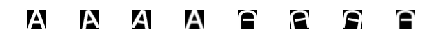

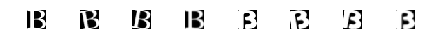

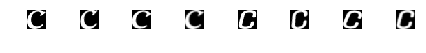

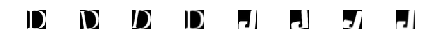

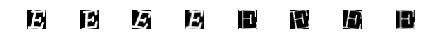

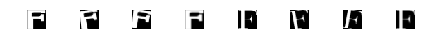

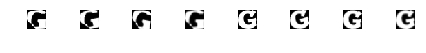

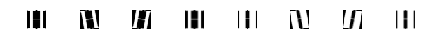

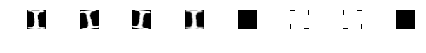

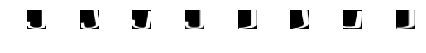

In [15]:
X_train, X_test, y_train, y_test = load_notmnist_dataset(normalize=True)

In [16]:
net = NetNotMnist()
net.fit(X_train, y_train, lr=0.001, epochs=40)
print(f'train score: {(y_train == net.predict(X_train)).sum().item() / X_train.shape[0]:0.5f}')
print(f'test score: {(y_test == net.predict(X_test)).sum().item() / X_test.shape[0]:0.5f}')

epoch=0, train_score: 0.91314, val_score: 0.91263
train_loss: 0.29628, val_loss: 0.30036
epoch=1, train_score: 0.93045, val_score: 0.92607
train_loss: 0.22424, val_loss: 0.23588
epoch=2, train_score: 0.93946, val_score: 0.93408
train_loss: 0.19341, val_loss: 0.21081
epoch=3, train_score: 0.94649, val_score: 0.94184
train_loss: 0.16850, val_loss: 0.18803
epoch=4, train_score: 0.95099, val_score: 0.94551
train_loss: 0.15231, val_loss: 0.17327
epoch=5, train_score: 0.95450, val_score: 0.94718
train_loss: 0.13996, val_loss: 0.16642
epoch=6, train_score: 0.95748, val_score: 0.94985
train_loss: 0.12642, val_loss: 0.15429
epoch=7, train_score: 0.95927, val_score: 0.95035
train_loss: 0.12341, val_loss: 0.15050
epoch=8, train_score: 0.96242, val_score: 0.95536
train_loss: 0.11475, val_loss: 0.14201
epoch=9, train_score: 0.96330, val_score: 0.95511
train_loss: 0.10953, val_loss: 0.13898
epoch=10, train_score: 0.96455, val_score: 0.95527
train_loss: 0.10652, val_loss: 0.13541
epoch=11, train_scor